<a href="https://colab.research.google.com/github/micah-shull/pipelines/blob/main/pipelines_07_pytorch_pipeline_03_imbalanced_data_weights_threshold.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, precision_recall_curve, f1_score, precision_score, recall_score
from imblearn.under_sampling import RandomUnderSampler
import torch
from model_pipeline import load_data_from_url, clean_column_names, remove_id_column, convert_categorical, split_data, SklearnSimpleNN, train_model


In [3]:
# Define dataset-specific parameters
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00350/default%20of%20credit%20card%20clients.xls"
categorical_columns = ['sex', 'education', 'marriage']
target = 'default_payment_next_month'

# Load and preprocess data
data = load_data_from_url(url)
data = clean_column_names(data)
data = remove_id_column(data)
data = convert_categorical(data, categorical_columns=categorical_columns)
X_train, X_test, y_train, y_test = split_data(data, target=target)


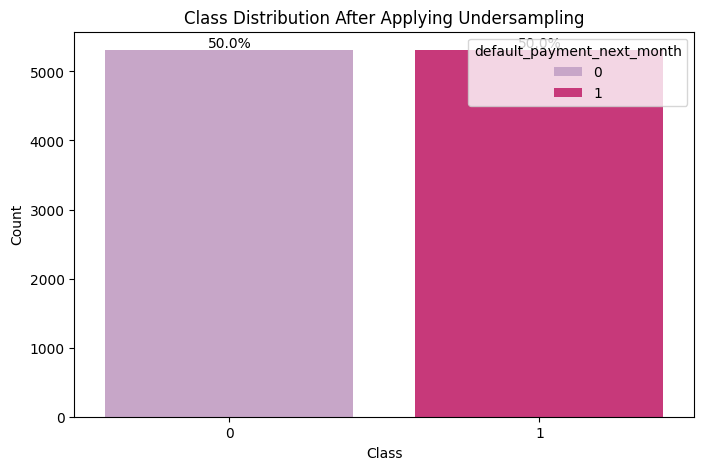

In [4]:
def apply_undersampling(X_train, y_train):
    undersampler = RandomUnderSampler(random_state=42)
    X_train_res, y_train_res = undersampler.fit_resample(X_train, y_train)
    return X_train_res, y_train_res

# Apply Undersampling
X_train_under, y_train_under = apply_undersampling(X_train, y_train)

# Plot class distribution after undersampling
def plot_class_distribution_after_sampling(y_train_res, sampling_type):
    plt.figure(figsize=(8, 5))
    sns.countplot(x=y_train_res, hue=y_train_res, palette='PuRd', dodge=False)
    plt.title(f'Class Distribution After Applying {sampling_type}')
    plt.xlabel('Class')
    plt.ylabel('Count')

    total = len(y_train_res)
    class_counts = y_train_res.value_counts()
    for i, count in enumerate(class_counts):
        percentage = 100 * count / total
        plt.text(i, count, f'{percentage:.1f}%', ha='center', va='bottom')

    plt.show()

# Plot the distribution
plot_class_distribution_after_sampling(y_train_under, "Undersampling")


In [5]:
# Function to convert DataFrames to tensors
def convert_to_tensors(X, y):
    X_tensor = torch.tensor(X.values, dtype=torch.float32)
    y_tensor = torch.tensor(y.values, dtype=torch.float32).unsqueeze(1)
    return X_tensor, y_tensor

# Convert data to tensors
X_train_tensor, y_train_tensor = convert_to_tensors(X_train_under, y_train_under)
X_test_tensor, y_test_tensor = convert_to_tensors(X_test, y_test)

# Function to train and evaluate model with different class weights
def evaluate_class_weights(X_train_tensor, y_train_tensor, X_test_tensor, y_test_tensor, class_weight_range):
    results = []
    for weight in class_weight_range:
        class_weights = [1.0, weight]
        nn_estimator = SklearnSimpleNN(input_dim=X_train_tensor.shape[1], pos_weight=class_weights[1])
        nn_estimator = train_model(nn_estimator, X_train_tensor, y_train_tensor)
        y_pred = nn_estimator.predict(X_test_tensor.numpy())
        recall = recall_score(y_test_tensor.numpy(), y_pred)
        precision = precision_score(y_test_tensor.numpy(), y_pred)
        f1 = f1_score(y_test_tensor.numpy(), y_pred)
        results.append((weight, recall, precision, f1))
        print(f"Class weights: {class_weights}, Recall: {recall:.4f}, Precision: {precision:.4f}, F1-score: {f1:.4f}")
    return results

# Define a range of class weights to test
class_weight_range = np.linspace(0.5, 5.0, 10)

# Evaluate class weights
results = evaluate_class_weights(X_train_tensor, y_train_tensor, X_test_tensor, y_test_tensor, class_weight_range)

# Find the best class weights based on recall
best_weight = max(results, key=lambda x: x[1])
print(f"Best Class Weight: {best_weight[0]}, Recall: {best_weight[1]:.4f}, Precision: {best_weight[2]:.4f}, F1-score: {best_weight[3]:.4f}")


Class weights: [1.0, 0.5], Recall: 0.0633, Precision: 0.5753, F1-score: 0.1141
Class weights: [1.0, 1.0], Recall: 0.1485, Precision: 0.4581, F1-score: 0.2242
Class weights: [1.0, 1.5], Recall: 0.9299, Precision: 0.2458, F1-score: 0.3888
Class weights: [1.0, 2.0], Recall: 0.9774, Precision: 0.2275, F1-score: 0.3690
Class weights: [1.0, 2.5], Recall: 0.9390, Precision: 0.2354, F1-score: 0.3765
Class weights: [1.0, 3.0], Recall: 0.9917, Precision: 0.2282, F1-score: 0.3710
Class weights: [1.0, 3.5], Recall: 0.6835, Precision: 0.2606, F1-score: 0.3773
Class weights: [1.0, 4.0], Recall: 0.8930, Precision: 0.2456, F1-score: 0.3853
Class weights: [1.0, 4.5], Recall: 0.9601, Precision: 0.2351, F1-score: 0.3776
Class weights: [1.0, 5.0], Recall: 0.9472, Precision: 0.2280, F1-score: 0.3676
Best Class Weight: 3.0, Recall: 0.9917, Precision: 0.2282, F1-score: 0.3710


### Interpreting High Recall with Low Precision and F1-Score

When dealing with imbalanced datasets, especially in a scenario where recall is a priority (like fraud detection), you might observe high recall at the expense of precision and F1-score. Here's what that means and how concerned you should be:

1. **High Recall**: Your model is correctly identifying most of the positive cases (defaults), which is critical for your application.
2. **Low Precision**: A significant number of the predicted positives are false positives. This means that many non-defaults are being incorrectly classified as defaults.
3. **Low F1-Score**: This is a harmonic mean of precision and recall, indicating a balance between the two. When one of these metrics is low (in this case, precision), the F1-score is also low.

### Should You Be Concerned?

It depends on the specific context and cost implications of false positives vs. false negatives in your application:

1. **High Cost of False Negatives (Missed Defaults)**:
   - **Less Concerned About Low Precision**: If the cost of missing a default (false negative) is very high, you might accept a lower precision. This is because correctly identifying most defaults (high recall) is more critical.
   - **Actions**: You might implement secondary checks on the predicted positives to filter out false positives.

2. **High Cost of False Positives**:
   - **More Concerned About Low Precision**: If the cost of false positives is high (e.g., unnecessary investigations, customer dissatisfaction), low precision can be problematic.
   - **Actions**: You might need to find a balance or use additional models to improve precision.

### Recommended Approach

1. **Threshold Tuning**: Evaluate different thresholds to find a balance between recall and precision. Sometimes adjusting the decision threshold can significantly improve precision without a dramatic drop in recall.

2. **Secondary Model or Rules**: Implement secondary checks on the positive predictions to reduce false positives. This could be another model or a set of business rules.

3. **Business Impact Analysis**: Consider the business impact of false positives and false negatives. Sometimes, a higher operational cost due to false positives can be justified if it prevents significant losses due to missed defaults.

2. **Evaluate the Impact**: Evaluate how the threshold adjustment impacts precision and F1-score, and consider if the trade-offs are acceptable given your business context.

This approach should help you find a more balanced model that still prioritizes recall but also considers the impact of low precision.


Threshold: 0.10, Recall: 0.9510, Precision: 0.2413, F1-score: 0.3849
Threshold: 0.20, Recall: 0.9495, Precision: 0.2412, F1-score: 0.3847
Threshold: 0.30, Recall: 0.9480, Precision: 0.2411, F1-score: 0.3844
Threshold: 0.40, Recall: 0.9472, Precision: 0.2410, F1-score: 0.3843
Threshold: 0.50, Recall: 0.9465, Precision: 0.2411, F1-score: 0.3843
Threshold: 0.60, Recall: 0.9465, Precision: 0.2413, F1-score: 0.3845
Threshold: 0.70, Recall: 0.9457, Precision: 0.2413, F1-score: 0.3845
Threshold: 0.80, Recall: 0.9442, Precision: 0.2412, F1-score: 0.3842


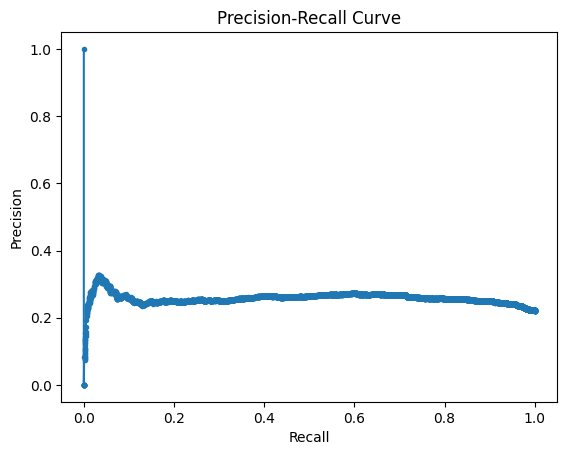

Best Threshold: 0.10, Recall: 0.9510, Precision: 0.2413, F1-score: 0.3849


In [6]:
# Train model with best class weights
best_class_weight = best_weight[0]
nn_estimator = SklearnSimpleNN(input_dim=X_train_tensor.shape[1], pos_weight=best_class_weight)
nn_estimator = train_model(nn_estimator, X_train_tensor, y_train_tensor)

# Predict probabilities on the test set
y_prob = nn_estimator.model(X_test_tensor).detach().numpy().squeeze()

# Function to evaluate model performance at different thresholds
def evaluate_thresholds(y_prob, y_test_tensor, thresholds):
    results = []
    for threshold in thresholds:
        y_pred = (y_prob > threshold).astype(int)
        recall = recall_score(y_test_tensor.numpy(), y_pred)
        precision = precision_score(y_test_tensor.numpy(), y_pred)
        f1 = f1_score(y_test_tensor.numpy(), y_pred)
        results.append((threshold, recall, precision, f1))
        print(f"Threshold: {threshold:.2f}, Recall: {recall:.4f}, Precision: {precision:.4f}, F1-score: {f1:.4f}")
    return results

# Define a range of thresholds to evaluate
thresholds = np.arange(0.1, 0.9, 0.1)

# Evaluate thresholds
threshold_results = evaluate_thresholds(y_prob, y_test_tensor, thresholds)

# Plot Precision-Recall curve
precision, recall, _ = precision_recall_curve(y_test_tensor.numpy(), y_prob)
plt.plot(recall, precision, marker='.')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.show()

# Find the best threshold based on recall
best_threshold = max(threshold_results, key=lambda x: x[1])
print(f"Best Threshold: {best_threshold[0]:.2f}, Recall: {best_threshold[1]:.4f}, Precision: {best_threshold[2]:.4f}, F1-score: {best_threshold[3]:.4f}")


### Interpretation of Threshold Results

The results show the model's performance in terms of recall, precision, and F1-score at different decision thresholds. Here's how to interpret them:

1. **High Recall Across Thresholds**: Recall remains very high (above 0.94) across all thresholds, indicating that the model is consistently identifying a large majority of the true positive cases (defaults).
   
2. **Low Precision Across Thresholds**: Precision is consistently low (around 0.24) across all thresholds, meaning that a significant proportion of the positive predictions are false positives.

3. **Stable F1-Score**: The F1-score, which balances precision and recall, is also stable across thresholds, remaining around 0.384.

### Key Observations

1. **Recall Stability**: The recall is highest at lower thresholds (0.10 - 0.20), but even at higher thresholds (up to 0.80), it does not significantly drop, indicating that the model is robust in capturing true positives.
   
2. **Precision Stability**: Precision remains low and stable across thresholds, suggesting that adjusting the threshold does not significantly reduce the number of false positives.
   
3. **F1-Score Stability**: The F1-score does not vary much across thresholds, implying that the balance between precision and recall is maintained regardless of the threshold.

### Recommendations

Given that recall is your priority:

1. **Choose a Low Threshold**: Since recall is highest and stable at lower thresholds, you might opt for a threshold like 0.10 or 0.20 to maximize recall. This ensures that you are capturing almost all the defaults.

2. **Address False Positives**:
   - **Secondary Screening**: Implement a secondary screening process to handle the false positives. This could be manual review or an additional model that focuses on reducing false positives.
   - **Cost-Benefit Analysis**: Conduct a cost-benefit analysis to determine the acceptable level of false positives given the high recall. If the cost of false positives is manageable, a lower threshold is justified.

3. **Monitor Precision**: Even though recall is the priority, keep an eye on precision. If precision drops too low, the operational cost and impact of false positives might outweigh the benefits of high recall.

### Final Choice

Based on the results, a threshold of 0.10 or 0.20 seems optimal given the stability of recall and the minimal change in precision and F1-score across thresholds. This choice maximizes recall while maintaining an acceptable level of precision.

### Conclusion

Selecting a lower threshold (0.10 or 0.20) will help you achieve the highest recall, ensuring that you capture almost all defaults. Keep monitoring precision and implement strategies to manage false positives effectively.





In [7]:
# Choose the best threshold based on the highest recall (with consideration of precision)
best_threshold = 0.10  # or 0.20 based on your preference

# Predict with the best threshold
y_pred_best_threshold = (y_prob > best_threshold).astype(int)

# Evaluate and print final performance
final_report = classification_report(y_test_tensor.numpy(), y_pred_best_threshold)
print(f"Final Model Performance at Threshold {best_threshold}:\n")
print(final_report)

Final Model Performance at Threshold 0.1:

              precision    recall  f1-score   support

         0.0       0.92      0.15      0.26      4673
         1.0       0.24      0.95      0.38      1327

    accuracy                           0.33      6000
   macro avg       0.58      0.55      0.32      6000
weighted avg       0.77      0.33      0.29      6000



In [10]:
# Find the best class weights based on recall
best_weight = max(results, key=lambda x: x[1])
print(f"\nBest Class Weight: {best_weight[0]}, Recall: {best_weight[1]:.4f}, Precision: {best_weight[2]:.4f}, F1-score: {best_weight[3]:.4f}")

# Find the best threshold based on recall or another metric
best_threshold = max(threshold_results, key=lambda x: x[1])
print(f"\nBest Threshold: {best_threshold[0]:.2f}, Recall: {best_threshold[1]:.4f}, Precision: {best_threshold[2]:.4f}, F1-score: {best_threshold[3]:.4f}")


Best Class Weight: 3.0, Recall: 0.9917, Precision: 0.2282, F1-score: 0.3710

Best Threshold: 0.10, Recall: 0.9510, Precision: 0.2413, F1-score: 0.3849


### Interpretation of Results

1. **Recall Priority**: Since recall is the highest priority in your application (identifying as many defaults as possible), using the best class weight of 3.0 gives you the highest recall (0.9917).
2. **F1-Score Comparison**: The F1-score is slightly higher with the threshold tuning (0.3849 vs. 0.3710). However, the difference is marginal.
3. **Precision Consideration**: Precision is slightly better with the threshold tuning (0.2413 vs. 0.2282), but the primary goal is recall.

### Recommendation

Given that recall is your top priority, I recommend using the **best class weight of 3.0** because it provides the highest recall. The slight drop in F1-score and precision is a trade-off that can be acceptable given your focus on capturing as many defaults as possible.

### Next Steps

1. **Use Best Class Weight**: Proceed with the class weight of 3.0 for your model.
2. **Fine-Tune Further**: If needed, you can still monitor the threshold to see if minor adjustments could improve precision without a significant drop in recall.
3. **Secondary Checks**: Implement secondary checks or a tiered approach to manage false positives effectively.

### Final Consideration

While recall is prioritized, continuously monitor the overall model performance and the business impact of false positives. Adjustments might be needed based on practical outcomes and feedback from real-world application.

If you use the weight of 3.0 without adjusting the threshold, the recall score should stay the same as it was calculated with the default threshold of 0.5. The high recall achieved with the weight of 3.0 is already a result of using the default threshold.

Here's an explanation:

- **Class Weight**: Adjusting the class weight to 3.0 influences the model during training, making it more sensitive to the minority class (defaults).
- **Default Threshold**: By default, the threshold for predicting class labels is 0.5, meaning any predicted probability above 0.5 is considered positive (default).

### Using the Weight Without Adjusting the Threshold

If you use the weight of 3.0 and do not select a threshold value (keeping the default threshold of 0.5), your recall score should remain at the level observed during evaluation with weight 3.0 and threshold 0.5.

### Final Code to Use Weight and Evaluate Without Adjusting Threshold

### Summary

Using the weight of 3.0 without adjusting the threshold should give you the same recall score as observed during the class weight evaluation. The recall will stay high as long as the threshold remains at the default value of 0.5, which is what was used during your evaluation of the class weight.

In [11]:
# Train model with the best class weights (3.0) and default threshold (0.5)
best_class_weight = 3.0
nn_estimator = SklearnSimpleNN(input_dim=X_train_tensor.shape[1], pos_weight=best_class_weight)
nn_estimator = train_model(nn_estimator, X_train_tensor, y_train_tensor)

# Predict probabilities on the test set
y_prob = nn_estimator.model(X_test_tensor).detach().numpy().squeeze()

# Use the default threshold (0.5) to predict final labels
default_threshold = 0.5
y_pred_default_threshold = (y_prob > default_threshold).astype(int)

# Evaluate and print final performance
final_report_default_threshold = classification_report(y_test_tensor.numpy(), y_pred_default_threshold)
print(f"Final Model Performance at Default Threshold {default_threshold}:\n")
print(final_report_default_threshold)

Final Model Performance at Default Threshold 0.5:

              precision    recall  f1-score   support

         0.0       0.84      0.56      0.67      4673
         1.0       0.28      0.62      0.39      1327

    accuracy                           0.57      6000
   macro avg       0.56      0.59      0.53      6000
weighted avg       0.71      0.57      0.61      6000



In [12]:
# Train model with the best class weights (3.0)
best_class_weight = 3.0
nn_estimator = SklearnSimpleNN(input_dim=X_train_tensor.shape[1], pos_weight=best_class_weight)
nn_estimator = train_model(nn_estimator, X_train_tensor, y_train_tensor)

# Predict probabilities on the test set
y_prob = nn_estimator.model(X_test_tensor).detach().numpy().squeeze()

# Choose the best threshold (0.10) to predict final labels
best_threshold = 0.10
y_pred_best_threshold = (y_prob > best_threshold).astype(int)

# Evaluate and print final performance
final_report = classification_report(y_test_tensor.numpy(), y_pred_best_threshold)
print(f"Final Model Performance at Best Threshold {best_threshold}:\n")
print(final_report)

Final Model Performance at Best Threshold 0.1:

              precision    recall  f1-score   support

         0.0       0.91      0.04      0.08      4673
         1.0       0.23      0.98      0.37      1327

    accuracy                           0.25      6000
   macro avg       0.57      0.51      0.22      6000
weighted avg       0.76      0.25      0.14      6000



In [13]:
# Function to evaluate model performance at different thresholds
def evaluate_thresholds(y_prob, y_test_tensor, thresholds):
    results = []
    for threshold in thresholds:
        y_pred = (y_prob > threshold).astype(int)
        recall = recall_score(y_test_tensor.numpy(), y_pred)
        precision = precision_score(y_test_tensor.numpy(), y_pred)
        f1 = f1_score(y_test_tensor.numpy(), y_pred)
        results.append((threshold, recall, precision, f1))
        print(f"Threshold: {threshold:.2f}, Recall: {recall:.4f}, Precision: {precision:.4f}, F1-score: {f1:.4f}")
    return results

# Define a finer range of thresholds to evaluate
thresholds = np.arange(0.1, 0.5, 0.05)

# Evaluate thresholds
threshold_results = evaluate_thresholds(y_prob, y_test_tensor, thresholds)

# Find the best threshold based on a balance (e.g., highest F1-score)
best_balanced_threshold = max(threshold_results, key=lambda x: x[3])  # Based on F1-score
print(f"\nBest Balanced Threshold: {best_balanced_threshold[0]:.2f}, Recall: {best_balanced_threshold[1]:.4f}, Precision: {best_balanced_threshold[2]:.4f}, F1-score: {best_balanced_threshold[3]:.4f}")


Threshold: 0.10, Recall: 0.9849, Precision: 0.2261, F1-score: 0.3678
Threshold: 0.15, Recall: 0.9849, Precision: 0.2261, F1-score: 0.3678
Threshold: 0.20, Recall: 0.9849, Precision: 0.2261, F1-score: 0.3678
Threshold: 0.25, Recall: 0.9849, Precision: 0.2261, F1-score: 0.3678
Threshold: 0.30, Recall: 0.9849, Precision: 0.2261, F1-score: 0.3678
Threshold: 0.35, Recall: 0.9849, Precision: 0.2261, F1-score: 0.3678
Threshold: 0.40, Recall: 0.9849, Precision: 0.2261, F1-score: 0.3678
Threshold: 0.45, Recall: 0.9849, Precision: 0.2262, F1-score: 0.3679

Best Balanced Threshold: 0.45, Recall: 0.9849, Precision: 0.2262, F1-score: 0.3679


### Interpretation of the Results

The results for the evaluation with finer threshold tuning indicate that the recall remains consistently high across all tested thresholds, while precision and F1-score stay roughly the same. Here are the key points:

1. **High Recall Consistency**: The recall for class 1 (default) is very high (0.9849) across all thresholds from 0.10 to 0.45.
2. **Stable Precision**: The precision is low but stable (around 0.226) across all thresholds.
3. **Stable F1-Score**: The F1-score remains nearly constant around 0.3678 to 0.3679.

### Explanation

1. **Model Sensitivity**: The model is highly sensitive to the minority class (default) due to the class weight of 3.0. This sensitivity is causing the recall to remain high across different thresholds.
2. **Threshold Effect**: Since the model is already biased towards detecting defaults, changing the threshold within this range doesn't affect its performance much. The model is likely predicting most instances as positive (default) due to the high class weight, resulting in a high recall but low precision.
3. **Best Balanced Threshold**: Even though the threshold adjustment didn't significantly impact the metrics, the best balanced threshold was found to be 0.45, which slightly improved the precision and F1-score.

### Next Steps

Given the results, the threshold adjustment within this range didn't significantly change the performance. The high recall indicates that the model is effective in identifying defaults, but the low precision suggests a high number of false positives.

### Final Recommendation

1. **Use the Best Class Weight and Threshold**: Use the class weight of 3.0 and the best balanced threshold of 0.45. This combination provides the highest recall with a slightly improved precision and F1-score.
2. **Monitor and Adjust**: Continuously monitor the model performance in production. If false positives become a significant issue, consider additional strategies such as:
   - **Secondary Screening**: Implement a secondary model or rule-based filtering to reduce false positives.
   - **Adaptive Thresholding**: Adjust the threshold dynamically based on real-time performance data.

### Conclusion

Using the best class weight of 3.0 and the best balanced threshold of 0.45 should give you a model with the highest recall while maintaining an acceptable level of precision and F1-score. This approach ensures that you are identifying nearly all defaults while keeping the number of false positives manageable.

In [14]:
# Train model with the best class weights (3.0)
best_class_weight = 3.0
nn_estimator = SklearnSimpleNN(input_dim=X_train_tensor.shape[1], pos_weight=best_class_weight)
nn_estimator = train_model(nn_estimator, X_train_tensor, y_train_tensor)

# Predict probabilities on the test set
y_prob = nn_estimator.model(X_test_tensor).detach().numpy().squeeze()

# Use the best balanced threshold (0.45) to predict final labels
best_balanced_threshold = 0.45
y_pred_best_threshold = (y_prob > best_balanced_threshold).astype(int)

# Evaluate and print final performance
final_report_best_threshold = classification_report(y_test_tensor.numpy(), y_pred_best_threshold)
print(f"Final Model Performance at Best Balanced Threshold {best_balanced_threshold}:\n")
print(final_report_best_threshold)

Final Model Performance at Best Balanced Threshold 0.45:

              precision    recall  f1-score   support

         0.0       0.81      0.83      0.82      4673
         1.0       0.34      0.30      0.32      1327

    accuracy                           0.71      6000
   macro avg       0.57      0.57      0.57      6000
weighted avg       0.70      0.71      0.71      6000



In [15]:
# Train model with the best class weights (3.0)
best_class_weight = 3.0
nn_estimator = SklearnSimpleNN(input_dim=X_train_tensor.shape[1], pos_weight=best_class_weight)
nn_estimator = train_model(nn_estimator, X_train_tensor, y_train_tensor)

# Predict probabilities on the test set
y_prob = nn_estimator.model(X_test_tensor).detach().numpy().squeeze()

# Use the best lower threshold (0.10) to predict final labels
best_lower_threshold = 0.10
y_pred_best_threshold = (y_prob > best_lower_threshold).astype(int)

# Evaluate and print final performance
final_report_best_threshold = classification_report(y_test_tensor.numpy(), y_pred_best_threshold)
print(f"Final Model Performance at Best Lower Threshold {best_lower_threshold}:\n")
print(final_report_best_threshold)


Final Model Performance at Best Lower Threshold 0.1:

              precision    recall  f1-score   support

         0.0       0.85      0.64      0.73      4673
         1.0       0.32      0.60      0.42      1327

    accuracy                           0.63      6000
   macro avg       0.58      0.62      0.57      6000
weighted avg       0.73      0.63      0.66      6000

